/tmp/ipykernel_764076/1142049231.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(GRAPH_PATH)


✅ Computed class weights: [0.2585694 2.7208006 5.865023  4.5368295 2.6730337]
Epoch 010 | Loss: 1.5818
Epoch 020 | Loss: 1.4717
Epoch 030 | Loss: 1.4392
Epoch 040 | Loss: 1.4126
Epoch 050 | Loss: 1.4005
Epoch 060 | Loss: 1.3882
Epoch 070 | Loss: 1.3788
Epoch 080 | Loss: 1.3587
Epoch 090 | Loss: 1.3587
Epoch 100 | Loss: 1.3431
Epoch 110 | Loss: 1.3542
Epoch 120 | Loss: 1.3548
Epoch 130 | Loss: 1.3422
Epoch 140 | Loss: 1.3342
Epoch 150 | Loss: 1.3370
Epoch 160 | Loss: 1.3461
Epoch 170 | Loss: 1.3435
Epoch 180 | Loss: 1.3300
Epoch 190 | Loss: 1.3375
Epoch 200 | Loss: 1.3525
Epoch 210 | Loss: 1.3274
Epoch 220 | Loss: 1.3154
Epoch 230 | Loss: 1.3408
Epoch 240 | Loss: 1.3624
Epoch 250 | Loss: 1.3259
Epoch 260 | Loss: 1.3362
Epoch 270 | Loss: 1.3146
Epoch 280 | Loss: 1.3564
Epoch 290 | Loss: 1.3387
Epoch 300 | Loss: 1.3301
               precision    recall  f1-score   support

Non-druggable      0.935     0.562     0.702     14721
       Tier 1      0.264     0.478     0.340      1399
      

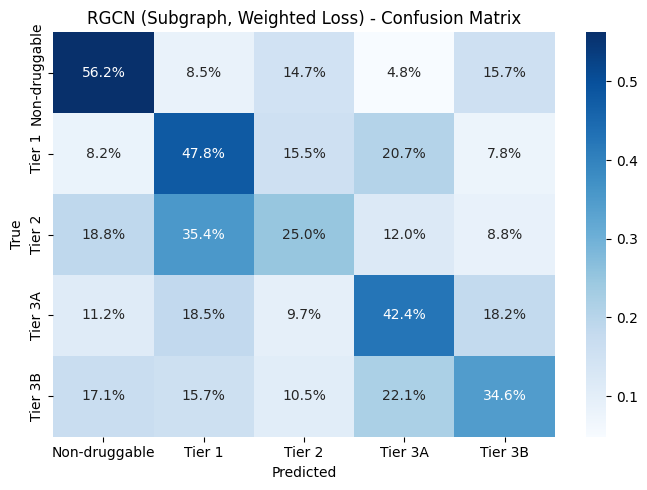

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data
from torch_geometric.utils import subgraph
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ---------------------- SETUP ----------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"
NUM_EPOCHS = 300
BATCH_SIZE = 8000
NUM_CLASSES = 5
HIDDEN_DIM = 64

# ---------------------- LOAD DATA ----------------------
data = torch.load(GRAPH_PATH)
data.x[torch.isnan(data.x)] = 0

# Convert y to tensor
if isinstance(data.y, (np.ndarray, list)):
    y_raw = np.array(data.y)
elif not isinstance(data.y, torch.Tensor):
    y_raw = np.asarray(data.y)
else:
    y_raw = data.y.cpu().numpy()

# Label mapping
label_map = {'-1': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 3A': 3, 'Tier 3B': 4}
if y_raw.dtype.kind in {'U', 'S', 'O'}:
    y = np.vectorize(label_map.get)(y_raw)
    data.y = torch.tensor(y, dtype=torch.long)

data = data.to(DEVICE)

# ---------------------- CLASS WEIGHTS ----------------------
y_all_np = data.y.cpu().numpy()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_all_np), y=y_all_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)
print(f"✅ Computed class weights: {class_weights.cpu().numpy()}")

# ---------------------- MODEL ----------------------
class RGCN_Multi(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations=num_relations)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations=num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

model = RGCN_Multi(
    data.num_node_features,
    HIDDEN_DIM,
    NUM_CLASSES,
    num_relations=data.edge_type.max().item() + 1
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# ---------------------- TRAINING ----------------------
def train():
    model.train()
    total_loss = 0
    indices = np.arange(data.num_nodes)
    np.random.shuffle(indices)

    for i in range(0, data.num_nodes, BATCH_SIZE):
        sampled_indices = indices[i:i + BATCH_SIZE]
        subset_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=DEVICE)
        subset_mask[sampled_indices] = True

        sub_edge_index, sub_edge_type = subgraph(
            subset_mask,
            data.edge_index,
            relabel_nodes=True,
            return_edge_mask=False,
            num_nodes=data.num_nodes,
            edge_attr=data.edge_type
        )

        x_sub = data.x[subset_mask]
        y_sub = data.y[subset_mask]

        sub_data = Data(
            x=x_sub,
            edge_index=sub_edge_index,
            edge_type=sub_edge_type,
            y=y_sub
        ).to(DEVICE)

        out = model(sub_data.x, sub_data.edge_index, sub_data.edge_type)
        loss = loss_fn(out, sub_data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    return total_loss / ((data.num_nodes // BATCH_SIZE) + 1)

# ---------------------- EVALUATION ----------------------
@torch.no_grad()
def evaluate(batch_size=2048):
    model.eval()
    y_true, y_pred = [], []

    for i in range(0, data.num_nodes, batch_size):
        batch_nodes = torch.arange(i, min(i + batch_size, data.num_nodes), device=DEVICE)
        batch_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=DEVICE)
        batch_mask[batch_nodes] = True

        sub_edge_index, sub_edge_type = subgraph(
            batch_mask,
            data.edge_index,
            relabel_nodes=True,
            return_edge_mask=False,
            num_nodes=data.num_nodes,
            edge_attr=data.edge_type
        )

        sub_x = data.x[batch_mask]
        sub_y = data.y[batch_mask]

        out = model(sub_x, sub_edge_index, sub_edge_type)
        preds = out.argmax(dim=1)

        y_true.append(sub_y.cpu())
        y_pred.append(preds.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    return y_true, y_pred

# ---------------------- TRAIN LOOP ----------------------
for epoch in range(1, NUM_EPOCHS + 1):
    loss = train()
    if epoch % 10 == 0 or epoch == NUM_EPOCHS:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f}")

# ---------------------- REPORT ----------------------
y_true, y_pred = evaluate(batch_size=2048)
class_names = ["Non-druggable", "Tier 1", "Tier 2", "Tier 3A", "Tier 3B"]
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# ---------------------- CONFUSION MATRIX ----------------------
cm = confusion_matrix(y_true, y_pred, normalize="true")
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt=".1%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("RGCN (Subgraph, Weighted Loss) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [5]:
model(data.x, data.edge_index)

tensor([[-0.0905,  0.1517,  0.2919, -0.1648, -0.1502],
        [-0.0833,  0.0317,  0.1174, -0.0347, -0.0546],
        [-0.1154,  0.1143,  0.3079, -0.1380, -0.1132],
        ...,
        [-0.1686,  0.0355,  0.2188, -0.0090, -0.0513],
        [-0.1513, -0.0648,  0.2258,  0.0489,  0.0064],
        [-0.2199, -0.1159,  0.4000,  0.0635,  0.0366]], device='cuda:0',
       grad_fn=<AddBackward0>)